In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy

In [2]:
%matplotlib widget
#plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
# create signal
srate = 1000 # Hz
time  = np.arange(0,3,1/srate)
n     = len(time)
p     = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl   = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
noise  = noiseamp * np.random.randn(n)
signal = ampl + noise

# initialize filtered signal vector
filtsig = np.zeros(n)

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k,n-k):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k+1])

# compute window size in ms
windowsize = 1000*(k*2+1) / srate


# plot the noisy and filtered signals

fig1 = plt.figure()
plt.plot(time,signal,label='orig')
plt.plot(time,filtsig,label='filtered')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

plt.show()


Try to denoising signal

In [ ]:
# import data
data = sio.loadmat('denoising_codeChallenge.mat')

origin_signal = data['origSignal'][0]
cleaned_signal = data['cleanedSignal'][0]

windowsize = 1

# plot the original and well filtered signals
fig2 = plt.figure()
plt.plot(origin_signal, label='orig')
plt.plot(cleaned_signal, label='filtered')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

plt.show()


In [ ]:
# Calculate RMS and Variance for original signal
origin_var = np.var(origin_signal)
origin_rms = np.sqrt(np.mean( origin_signal**2 ))

# Calculate RMS and Variance for well filtered signal
cleaned_var = np.var(cleaned_signal)
cleaned_rms = np.sqrt(np.mean( cleaned_signal**2 ))


variability = {'origin_var': origin_var, 'origin_rms': origin_rms,
               'cleaned_var': cleaned_var, 'cleaned_rms': cleaned_rms}

for key, val in variability.items():
    print(f"{key}: {val}")

In [ ]:
(np.mean(origin_signal), np.mean(cleaned_signal))

# 1. Filtered spikes
## Median-smoothing spikes


In [ ]:
# Let's see distribution of spikes

fig3 = plt.figure()
plt.hist(origin_signal, 100, histtype='bar')
plt.show()

In [ ]:
# visual-picked threshold
threshold = 5

# find data values below the threshold
#suprathresh = np.where( origin_signal < threshold )[0]
a = np.array(range(0,10))
a[a > 5] = 0
a
# initialize filtered signal
filtsig = copy.deepcopy(origin_signal)

# replace values that less than threshold by 0
filtsig[(filtsig > threshold) | (filtsig < -threshold)] = 0

# plot
fig4 = plt.figure()
plt.plot(origin_signal, label='orig')
plt.plot(filtsig, label='filtered')
plt.plot(cleaned_signal, label='cleaned')

plt.legend()
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d-ms filter' %windowsize)

#plt.plot(range(0,len(origin_signal)), origin_signal, range(0,len(origin_signal)),filtsig)
plt.show()

In [ ]:
# Overview distribution of filtered signal
fig6 = plt.figure()
plt.hist(filtsig, 100, histtype='bar')
plt.show()

## 2. Mean-smoothing

In [ ]:
## implement the filter

# initialize filtered signal vector
filtsigMean = copy.deepcopy(filtsig)
n = len(origin_signal)
# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 100 # filter window is actually mk*2+1
for i in range(mk+1,n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = np.mean(filtsig[i-mk:i+mk+1])

# plot
fig8 = plt.figure()
#plt.plot(origin_signal,'r',label='Original')
#plt.plot(filtsig,'k',label='Spike-filtered')
plt.plot(cleaned_signal,'r',label='Cleaned')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.plot(filtsigMean,'b',label='Running mean')
plt.legend()
plt.show()

## 3. Smoothing (Gaussian or RM)

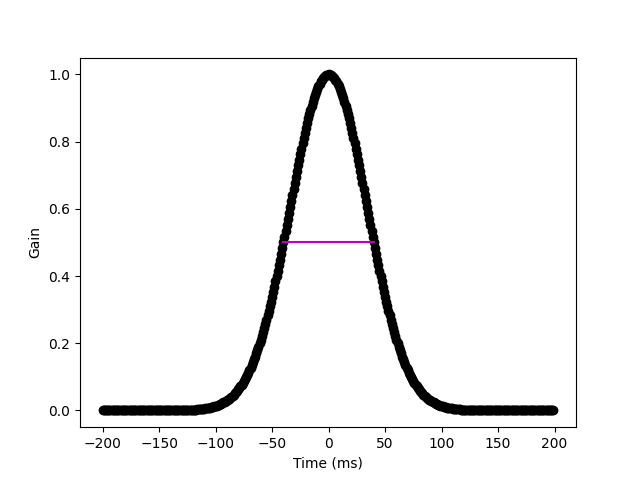

In [78]:
## Create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 80 # in ms

# normalized time vector in ms
k = 200
gtime = np.arange(-k,k+0)

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# compute empirical FWHM
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

#gaussian_smoothing.locals = locals()

fig7 = plt.figure()
# show the Gaussian
plt.plot(gtime,gauswin,'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

# then normalize Gaussian to unit energy
#gauswin = gauswin / np.sum(gauswin)
# title([ 'Gaussian kernel with requeted FWHM ' num2str(fwhm) ' ms (' num2str(empFWHM) ' ms achieved)' ])
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()

In [ ]:
i = k + 1
len(origin_signal[i-k:i+k+0])
len(gauswin)

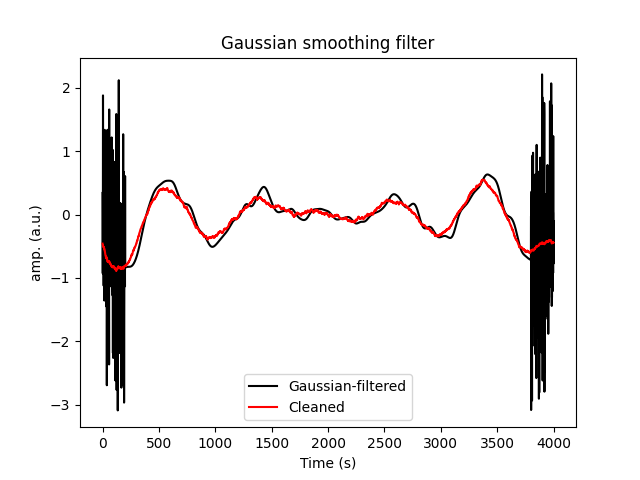

In [80]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(filtsig)

# # implement the running mean filter
for i in range(k+1,n-k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum( filtsig[i-k:i+k+0]*gauswin )

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)

# plot
fig9 = plt.figure()
#plt.plot(origin_signal,'b',label='Original')
#plt.plot(filtsig,'b',label='Spike-filtered')
plt.plot(filtsigG,'k',label='Gaussian-filtered')
plt.plot(cleaned_signal,'r',label='Cleaned')
#plt.plot(filtsigMean,'g',label='Running mean')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

plt.show()